In [ ]:
import random
import tensorflow as tf

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
import tempfile
from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import pandas as pd
import seaborn as sns 
%matplotlib inline
from IPython.display import display, Image
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

from sklearn.model_selection import train_test_split
from sklearn.datasets import load_files       
from keras.utils import np_utils
from sklearn.utils import shuffle

from keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from keras.utils.vis_utils import plot_model
from tensorflow.keras.models import Sequential, save_model,Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.layers import Conv2D, MaxPooling2D

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
auth.authenticate_user() #authenticate your google account 
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id':"1JU67NOrwPu391EK2priRZBYrRzmBhbRq"})  #get file from google drive
downloaded.GetContentFile('bgkit.zip') 

In [ ]:
!unzip -q   '/content/bgkit.zip'

In [ ]:
IMAGE_SIZE = 128
BATCH_SIZE = 64



img_directory = '/content/imgs/train'




train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                                validation_split=0.2)
   
    
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,validation_split=0.2)
train_generator = train_datagen.flow_from_directory(
     '/content/imgs/train', #change it into your train directory
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    seed = 42,
    subset='training',
    shuffle=True)


val_generator = valid_datagen.flow_from_directory(
   '/content/imgs/train', #change it into your train directory
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    subset='validation',
    shuffle=True)


test_generator = test_datagen.flow_from_directory(
  '/content/imgs/test', #change it into your test directory
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE, 
    class_mode="categorical",
    shuffle=False)

Found 4000 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.
Found 21834 images belonging to 1 classes.


In [ ]:
for image_batch, label_batch in train_generator:
  break
image_batch.shape, label_batch.shape #Print the batch size and labels.

((64, 128, 128, 3), (64, 10))

In [ ]:
print (train_generator.class_indices)

labels = '\n'.join(sorted(train_generator.class_indices.keys()))

with open('labels.txt', 'w') as f:
  f.write(labels)

{'Doing Hair or Makeup': 0, 'Drinking': 1, 'Operating Radio': 2, 'Reaching Behind': 3, 'Save Driving': 4, 'Talking On The Phone left': 5, 'Talking On The phone Right': 6, 'Talking to passenger': 7, 'Texting Left': 8, 'Texting Right': 9}


In [ ]:
model1 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation=tf.nn.relu),
    tf.keras.layers.Dense(10, activation=tf.nn.softmax)])

checkpointer = tf.keras.callbacks.ModelCheckpoint('cnn_stratch_best.hdf5', verbose=1, save_best_only=True)
earlystop = EarlyStopping(monitor='val_accuracy', patience=2, verbose=1)
#opt = tf.keras.optimizers.Adam(learning_rate=0.0001) 
model1.compile(optimizer = 'RMSprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model1.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 126, 126, 512)     14336     
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 63, 63, 512)       0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 61, 61, 256)       1179904   
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 30, 30, 256)       0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 28, 28, 128)       295040    
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 12, 12, 64)      

In [ ]:
history = model1.fit(train_generator, 
                    steps_per_epoch=len(train_generator), 
                    epochs=10, 
                    validation_data=val_generator, 
                    validation_steps=len(val_generator),callbacks=[checkpointer,earlystop])

Epoch 1/10
63/63 [==============================] - ETA: 0s - loss: 2.3287 - accuracy: 0.2157
Epoch 00001: val_loss improved from inf to 1.71052, saving model to cnn_stratch_best.hdf5
63/63 [==============================] - 44s 694ms/step - loss: 2.3287 - accuracy: 0.2157 - val_loss: 1.7105 - val_accuracy: 0.4250
Epoch 2/10
63/63 [==============================] - ETA: 0s - loss: 1.0179 - accuracy: 0.6585
Epoch 00002: val_loss improved from 1.71052 to 0.64249, saving model to cnn_stratch_best.hdf5
63/63 [==============================] - 43s 686ms/step - loss: 1.0179 - accuracy: 0.6585 - val_loss: 0.6425 - val_accuracy: 0.7800
Epoch 3/10
63/63 [==============================] - ETA: 0s - loss: 0.5262 - accuracy: 0.8380
Epoch 00003: val_loss improved from 0.64249 to 0.39233, saving model to cnn_stratch_best.hdf5
63/63 [==============================] - 43s 686ms/step - loss: 0.5262 - accuracy: 0.8380 - val_loss: 0.3923 - val_accuracy: 0.8680
Epoch 4/10
63/63 [==========================

In [ ]:
def plot_train_history(history):
    # Summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

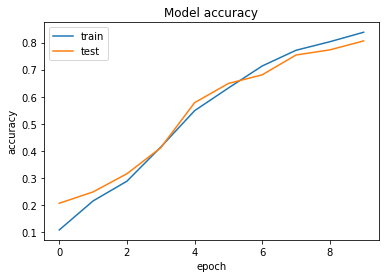

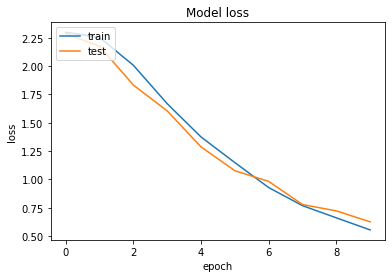

In [ ]:
plot_train_history(history)


In [ ]:
evaluate = model1.evaluate(test_generator, steps=24)
print('Accuracy: %.2f%%' % (evaluate[1]*100))

24/24 [==============================] - 12s 482ms/step - loss: 73.4518 - accuracy: 0.1064
Accuracy: 10.64%


In [ ]:
#pred= model1.predict(val_generator, 4000)
#predicted_class_indices=np.argmax(pred,axis=1)
#c
#labels2 = dict((v,k) for k,v in labels.items())
#predictions = [labels2[k] for k in predicted_class_indices]
#print(predicted_class_indices)
#print(labels)
#print(predictions)

[8 5 4 ... 5 9 5]
{'Doing Hair or Makeup': 0, 'Drinking': 1, 'Operating Radio': 2, 'Reaching Behind': 3, 'Save Driving': 4, 'Talking On The Phone left': 5, 'Talking On The phone Right': 6, 'Talking to passenger': 7, 'Texting Left': 8, 'Texting Right': 9}
['Texting Left', 'Talking On The Phone left', 'Save Driving', 'Talking On The Phone left', 'Talking On The Phone left', 'Texting Right', 'Operating Radio', 'Talking On The phone Right', 'Operating Radio', 'Operating Radio', 'Save Driving', 'Doing Hair or Makeup', 'Talking On The Phone left', 'Doing Hair or Makeup', 'Talking to passenger', 'Drinking', 'Talking On The Phone left', 'Operating Radio', 'Reaching Behind', 'Texting Left', 'Drinking', 'Talking On The Phone left', 'Operating Radio', 'Talking On The phone Right', 'Drinking', 'Doing Hair or Makeup', 'Reaching Behind', 'Talking On The phone Right', 'Operating Radio', 'Texting Left', 'Save Driving', 'Operating Radio', 'Operating Radio', 'Save Driving', 'Talking On The phone Right',

In [ ]:
print(confusion_matrix(y_true = predicted_class_indices,y_pred =labels))


ValueError: ignored